<a href="https://colab.research.google.com/github/mehdihosseinimoghadam/Signal-Processing/blob/main/vq_VAE_for_Melspectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1) Voice Reconstruction Using Vq-VAE

This notebook proposes a method on how to reconstruct speech using vq-vae which has been first introduced by [ Oord et. al](https://arxiv.org/abs/1711.00937).



![picture](https://drive.google.com/uc?export=view&id=1XFC5_OYnwge7g14jmKZqHaBwuajsVDyP)



#2) Vq-VAE vs VAE
Main difference between Vq-VAE & VAE is that VAE learns a continuous latent representation of a given dataset, but Vq-VAE learns a discrete latent representation of dataset.  



#3) Architecture

- At the begining, encoder takes a batch of images with input shape of $X:(n, h, w, c)$ and outputs $Z_{e}:(n, h, w, d)$

- Then vector quantization layer takes $Z_{e}$ and for each vector in $Z_{e}$ it selects the nearest vector from the codebook based on $L_{2}$ norm and outputs $Z_{q}$ 

- Finally decoder takes $Z_{q}$ and reconstructs the input $X$.


![picture](https://drive.google.com/uc?export=view&id=1hVMCRd4ZeBMM581iLa5ZKV1C-gT4IUsQ)


### References
[1] https://shashank7-iitd.medium.com/understanding-vector-quantized-variational-autoencoders-vq-vae-323d710a888a

[2] https://arxiv.org/pdf/1711.00937.pdf

## DataLoader





In [ ]:
import torch
from torch import nn
## Some imports
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as idp
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd

In [ ]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.figure(figsize=(10,30))
  plt.show(block=False)

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate = 16000

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d luantm/speech-commands-tensorflow

100% 4.50G/4.51G [01:03<00:00, 146MB/s]
100% 4.51G/4.51G [01:03<00:00, 76.6MB/s]


In [ ]:
%%capture
!unzip /content/speech-commands-tensorflow.zip

## DataLoader Structure

- Class: EnglishCommands
  - __init__
  - __len__
  - __getitem__
   - change_sample_rate
   - right_padding
   - mix_down
   - transformations
   - cut_signal


In [ ]:
import csv

with open('/content/speechdataset/SpeechDataset/testing_list.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split("/") for line in stripped if line)
    with open('log.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('command', 'path'))
        writer.writerows(lines)

In [ ]:
from matplotlib.cbook import get_label
from torch.utils.data import Dataset
import torchaudio
class EnglishCommands(Dataset):
  def __init__(self,
               annotation_file,
               audio_dir,
               target_sample_rate,
               transformation,
               num_sample):


    self.annotation_file = pd.read_csv(annotation_file).iloc[1:700,:]
    self.audio_dir = audio_dir
    self.target_sample_rate = target_sample_rate
    self.transformation = transformation
    self.num_sample = num_sample


  def __len__(self):
    return len(self.annotation_file)


  def __getitem__(self, index):
    path = self.get_path(index)
    label = self.get_label(index)
    signal, sr = torchaudio.load(path)
    signal = self.change_sample_rate(signal, sr)
    signal = self.right_padding(signal)
    signal = self.cut_signal(signal)
    signal = self.transformation(signal)
    return signal, label



  def get_path(self, index):
    path = str(self.audio_dir) + "/" + str(self.annotation_file.iloc[index,0]) + "/" + str(self.annotation_file.iloc[index,1])  
    return path


  def get_label(self, index):  
    return self.annotation_file.iloc[index,0]

  def change_sample_rate(self, signal, sr):
    if sr != self.target_sample_rate:  
       signal = torchaudio.transforms.Resample(sr, self.target_sample_rate)
       return signal  
    return signal   

  def right_padding(self, signal):
    if signal.shape[1] < self.num_sample:
      padd = self.num_sample - signal.shape[1] 
      last_dim_padding = (0, padd)
      signal = torch.nn.functional.pad(signal, last_dim_padding)
      return signal
    return signal  


  def cut_signal(self, signal): 
    if signal.shape[1] > self.num_sample:
       signal = signal[:, :self.num_sample]
       return signal
    return signal   


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


699
(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [8.2379e-05, 6.8455e-05, 7.2981e-05,  ..., 8.4224e-04,
          7.8313e-04, 3.3135e-04],
         [4.5151e-05, 9.4620e-05, 1.6976e-04,  ..., 1.1170e-03,
          2.0697e-03, 1.4809e-03],
         [5.3626e-05, 1.0129e-04, 2.3816e-04,  ..., 1.1962e-03,
          9.6486e-04, 2.2772e-04]]]), 'right')
torch.Size([1, 512, 64])


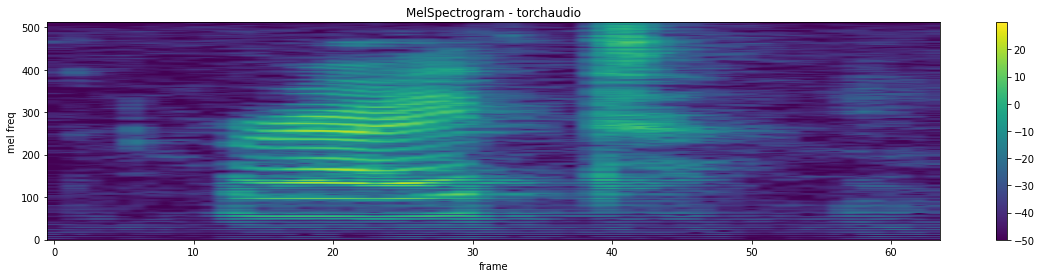

<Figure size 720x2160 with 0 Axes>

/content/speechdataset/SpeechDataset/right/692a88e6_nohash_3.wav


In [ ]:
SR = 16000
N_FFT=1024
HOP_LENGTH=253
N_MELS=512

melspec = torchaudio.transforms.MelSpectrogram(sample_rate = SR,
                                               n_fft = N_FFT,
                                               window_fn = torch.hann_window,
                                               hop_length = HOP_LENGTH,
                                               n_mels = N_MELS)

EC = EnglishCommands("/content/log.csv",
                "/content/speechdataset/SpeechDataset",
                16000,
                melspec,
                16000)

print(len(EC))
print(EC[6])
print(EC[6][0].shape)

plot_spectrogram(
    EC[100][0][0], title="MelSpectrogram - torchaudio", ylabel='mel freq')
print(EC.get_path(100))
ipd.Audio(EC.get_path(100))

## Full VAE Code

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
train_dataloader = DataLoader(EC, batch_size=32, shuffle=True)

## Train VAE

In [ ]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 32
img_size = (512, 64) # (width, height)

input_dim = 1
hidden_dim = 150
n_embeddings= 128
output_dim = 1

lr = 1e-4

epochs = 10000

print_step = 100

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, output_dim, kernel_4, padding=0)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x
        
        return y

In [ ]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                    torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                                torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.residual_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity

In [ ]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=hidden_dim)
decoder = Decoder(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

In [ ]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 904051


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

Start training VQ-VAE...


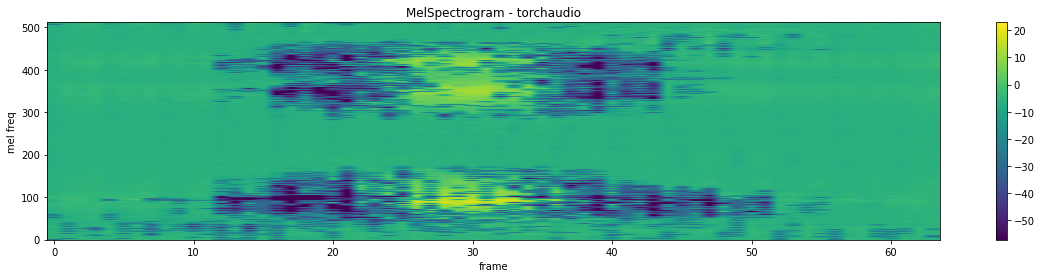

<Figure size 720x2160 with 0 Axes>

epoch: 1   step: 22   recon_loss: 6997.45849609375   perplexity:  25.102048873901367 
		commit_loss:  13912.494140625   codebook loss:  55649.9765625   total_loss:  76559.9296875


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


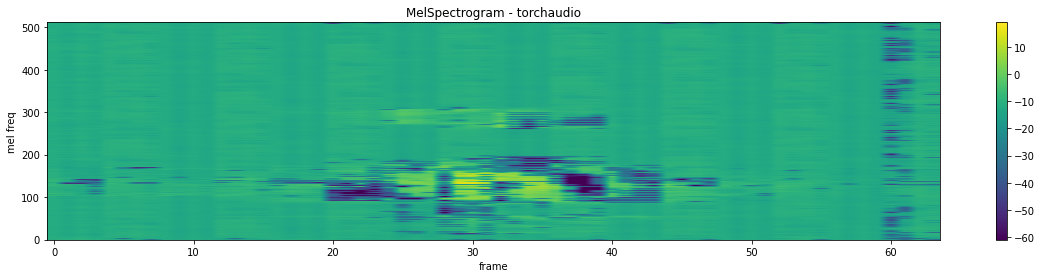

<Figure size 720x2160 with 0 Axes>

epoch: 51   step: 22   recon_loss: 364.3927917480469   perplexity:  4.003470420837402 
		commit_loss:  1515.4456787109375   codebook loss:  6061.78271484375   total_loss:  7941.62109375


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


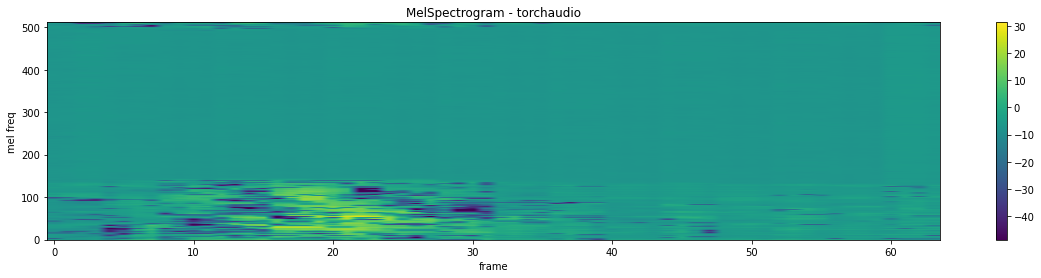

<Figure size 720x2160 with 0 Axes>

epoch: 101   step: 22   recon_loss: 363.40338134765625   perplexity:  2.6393227577209473 
		commit_loss:  1938.345947265625   codebook loss:  7753.3837890625   total_loss:  10055.1328125


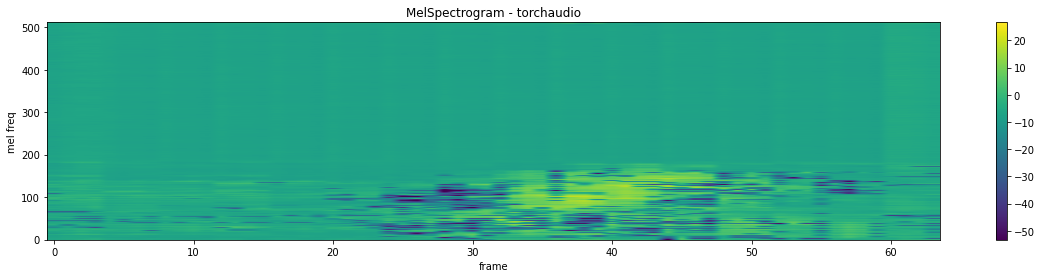

<Figure size 720x2160 with 0 Axes>

epoch: 151   step: 22   recon_loss: 200.68882751464844   perplexity:  2.2169063091278076 
		commit_loss:  560.816650390625   codebook loss:  2243.2666015625   total_loss:  3004.77197265625


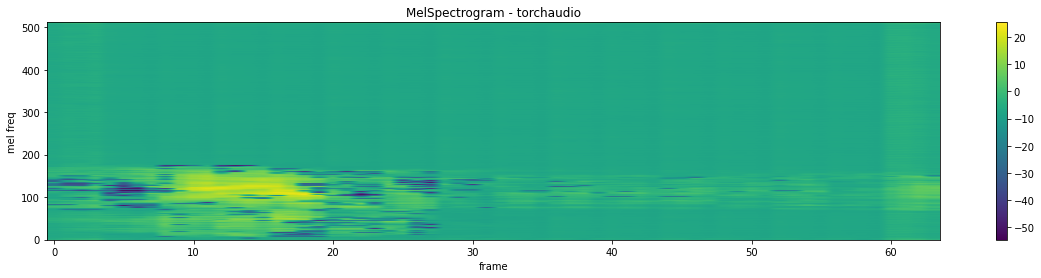

<Figure size 720x2160 with 0 Axes>

epoch: 201   step: 22   recon_loss: 93.9305191040039   perplexity:  1.3785594701766968 
		commit_loss:  509.9830627441406   codebook loss:  2039.9322509765625   total_loss:  2643.845703125


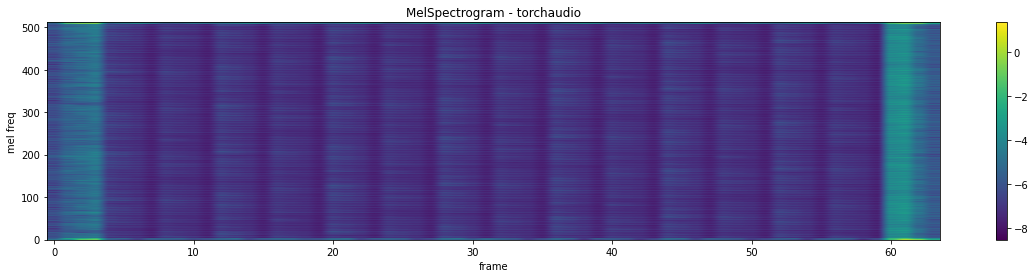

<Figure size 720x2160 with 0 Axes>

epoch: 251   step: 22   recon_loss: 434.3113098144531   perplexity:  2.4278388023376465 
		commit_loss:  2109.897705078125   codebook loss:  8439.5908203125   total_loss:  10983.7998046875


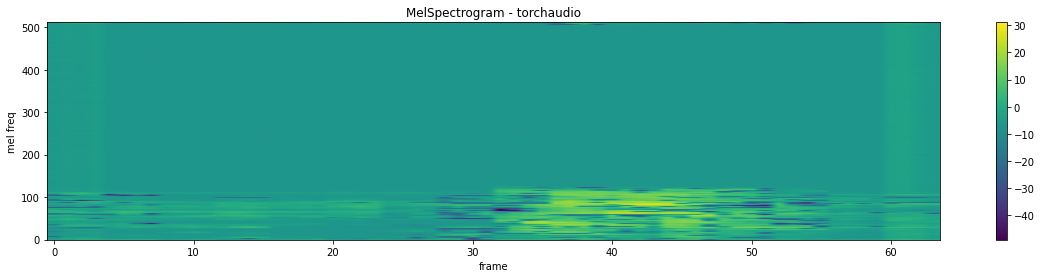

<Figure size 720x2160 with 0 Axes>

epoch: 301   step: 22   recon_loss: 311.928955078125   perplexity:  2.4202232360839844 
		commit_loss:  1285.4158935546875   codebook loss:  5141.66357421875   total_loss:  6739.00830078125


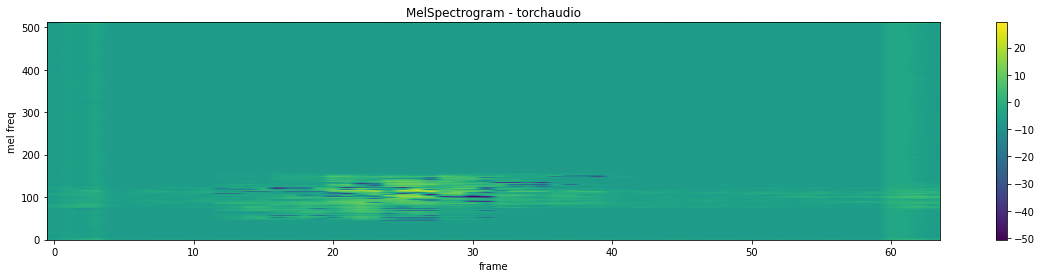

<Figure size 720x2160 with 0 Axes>

epoch: 351   step: 22   recon_loss: 231.5218048095703   perplexity:  2.1738200187683105 
		commit_loss:  1003.9072265625   codebook loss:  4015.62890625   total_loss:  5251.05810546875


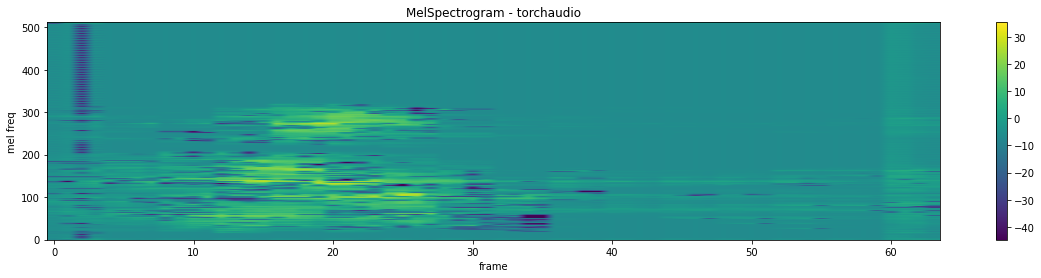

<Figure size 720x2160 with 0 Axes>

epoch: 401   step: 22   recon_loss: 304.7690734863281   perplexity:  2.210669994354248 
		commit_loss:  1705.80078125   codebook loss:  6823.203125   total_loss:  8833.7734375


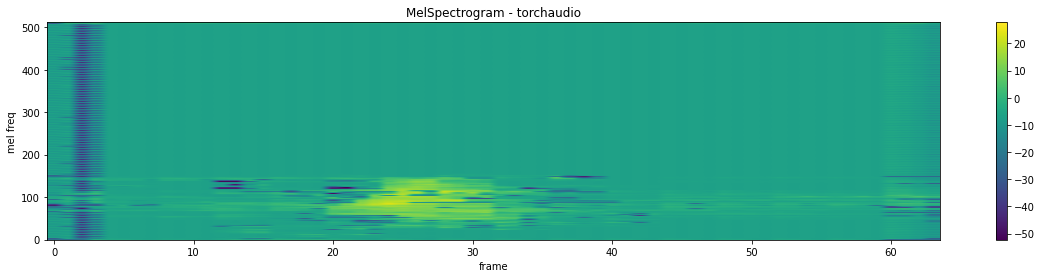

<Figure size 720x2160 with 0 Axes>

epoch: 451   step: 22   recon_loss: 217.25877380371094   perplexity:  1.8278107643127441 
		commit_loss:  690.2101440429688   codebook loss:  2760.840576171875   total_loss:  3668.3095703125


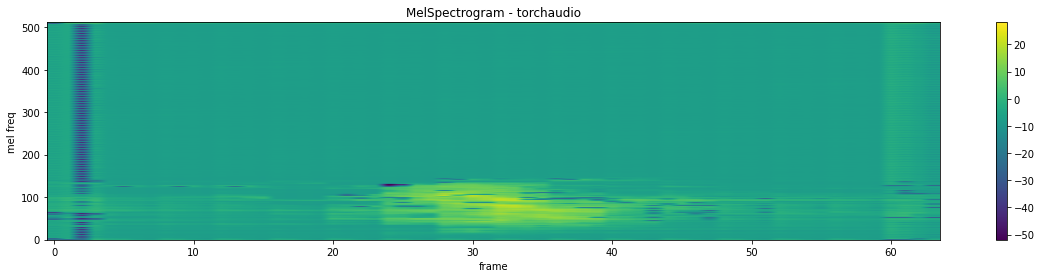

<Figure size 720x2160 with 0 Axes>

epoch: 501   step: 22   recon_loss: 188.17247009277344   perplexity:  1.738725185394287 
		commit_loss:  448.5933532714844   codebook loss:  1794.3734130859375   total_loss:  2431.13916015625


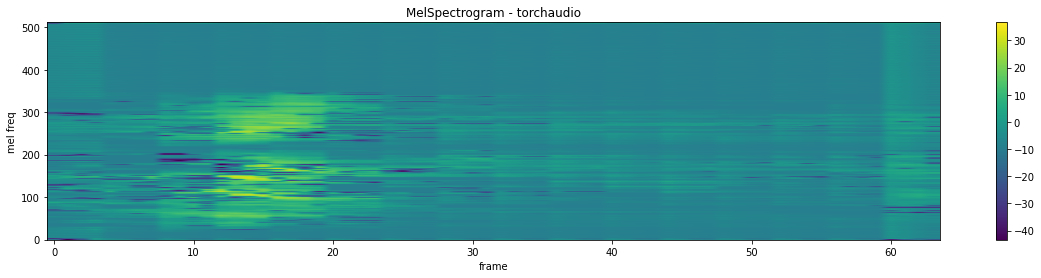

<Figure size 720x2160 with 0 Axes>

epoch: 551   step: 22   recon_loss: 187.70387268066406   perplexity:  2.015476942062378 
		commit_loss:  933.6537475585938   codebook loss:  3734.614990234375   total_loss:  4855.97265625


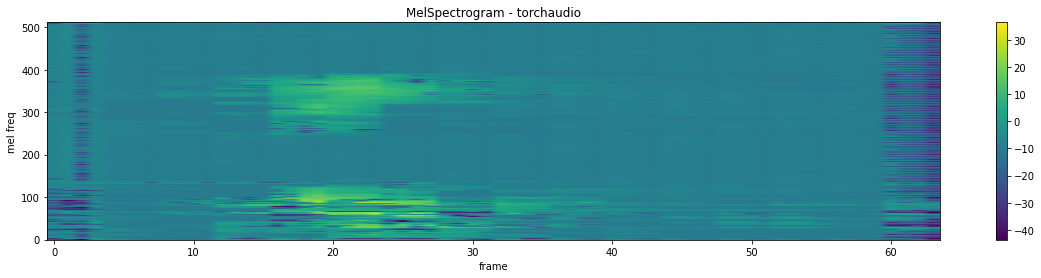

<Figure size 720x2160 with 0 Axes>

epoch: 601   step: 22   recon_loss: 185.39987182617188   perplexity:  2.192294120788574 
		commit_loss:  1032.357666015625   codebook loss:  4129.4306640625   total_loss:  5347.1884765625


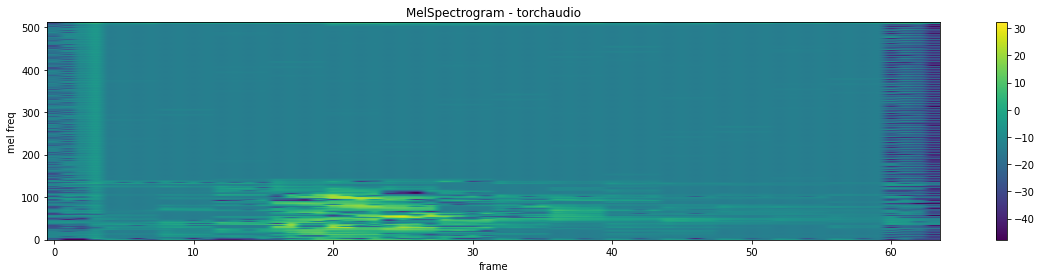

<Figure size 720x2160 with 0 Axes>

epoch: 651   step: 22   recon_loss: 185.44117736816406   perplexity:  2.4164528846740723 
		commit_loss:  741.2486572265625   codebook loss:  2964.99462890625   total_loss:  3891.6845703125


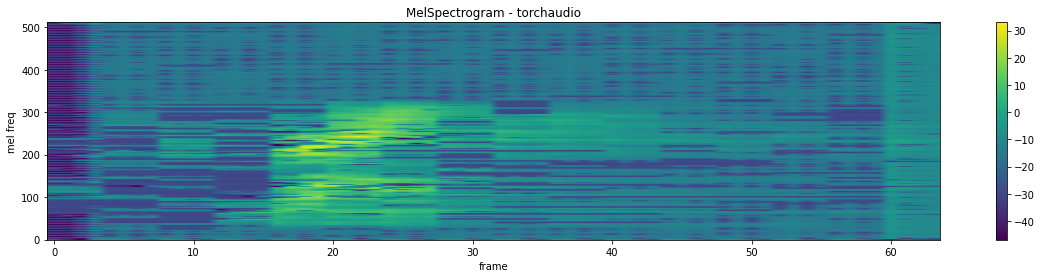

<Figure size 720x2160 with 0 Axes>

epoch: 701   step: 22   recon_loss: 177.32643127441406   perplexity:  2.279527425765991 
		commit_loss:  861.25   codebook loss:  3445.0   total_loss:  4483.576171875


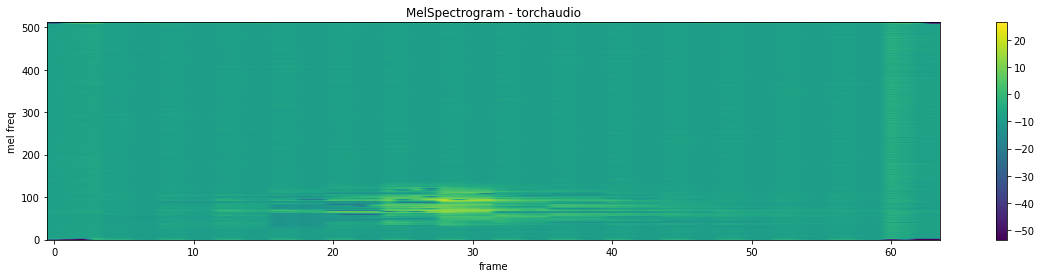

<Figure size 720x2160 with 0 Axes>

epoch: 751   step: 22   recon_loss: 90.19316101074219   perplexity:  1.8127038478851318 
		commit_loss:  335.820556640625   codebook loss:  1343.2822265625   total_loss:  1769.2958984375


In [ ]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_dataloader):
        x = x.to(DEVICE)
        # print(x.shape)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        # print(x_hat.shape)
        
        loss =  recon_loss + commitment_loss + codebook_loss
                
        loss.backward()
        optimizer.step()
        
    if epoch % 50 ==0:
            plot_spectrogram(
             x_hat[0][0].cpu().detach().numpy(), title="MelSpectrogram - torchaudio", ylabel='mel freq')   
            print("epoch:", epoch + 1, "  step:", batch_idx + 1, "  recon_loss:", recon_loss.item(), "  perplexity: ", perplexity.item(), 
              "\n\t\tcommit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item(), "  total_loss: ", loss.item())



            res = librosa.feature.inverse.mel_to_audio(x_hat[23][0].cpu().detach().numpy(), 
                                           sr=16000, 
                                           n_fft=1024, 
                                           hop_length=253, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2.0, 
                                           n_iter=32)

            # step4 - save it as a wav file
            import soundfile as sf
            sf.write("test1.wav", res, 16000)

    
print("Finish!!")

In [ ]:
x_hat[0].cpu().shape

torch.Size([1, 128, 32])

In [ ]:
res = librosa.feature.inverse.mel_to_audio(x_hat[23][0].cpu().detach().numpy(), 
                                           sr=22050, 
                                           n_fft=2048, 
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2.0, 
                                           n_iter=32)

# step4 - save it as a wav file
import soundfile as sf
sf.write("test1.wav", res, 22050)

In [ ]:
ipd.Audio("/content/test1.wav")